<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [7]:
TARGET_1 = 'btc_logret'

In [8]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [9]:
TARGET_2 = 'btc_logret'

In [10]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Lookback Window

In [11]:
def create_lagged_features(df, features, target, lookback):
  needed_columns = [target] + features

  temp = df[needed_columns].copy()

  for feature in features:
    for lag in range(1, lookback + 1):
      temp[f'{feature}_lag{lag}'] = temp[feature].shift(lag)

  temp['y'] = temp[target]

  temp = temp.dropna().reset_index(drop=True)

  return temp

In [12]:
LOOKBACK = 60

In [13]:
df_lagged_1 = create_lagged_features(df, FEATURES_1, TARGET_1, LOOKBACK)
df_lagged_2 = create_lagged_features(df, FEATURES_2, TARGET_2, LOOKBACK)

/tmp/ipython-input-3533996056.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[f'{feature}_lag{lag}'] = temp[feature].shift(lag)
/tmp/ipython-input-3533996056.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[f'{feature}_lag{lag}'] = temp[feature].shift(lag)
/tmp/ipython-input-3533996056.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [14]:
df_lagged_1

,btc_logret,btc_price,open,high,low,volume,btc_ma50,btc_ma200,btc_price_lag1,btc_price_lag2,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,245.424,249.8010,232.7,228.6,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,244.372,249.5535,232.2,232.7,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,243.384,249.3495,231.1,232.2,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,242.282,249.1050,231.1,231.1,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,241.250,248.8920,226.3,231.1,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,-0.003874,114108.0,114553.9,116307.5,113868.0,70790.0,114272.866,108948.3695,114550.9,111646.1,...,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,101077.9710,-0.003874
3693,-0.010592,112905.8,114110.3,116076.7,112266.9,52490.0,114289.614,109095.8330,114108.0,114550.9,...,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,-0.010592
3694,-0.025850,110024.6,112904.7,113628.7,109506.4,66990.0,114259.776,109219.4925,112905.8,114108.0,...,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,-0.025850
3695,-0.015613,108320.1,110024.9,111585.8,106371.4,80070.0,114146.908,109342.4210,110024.6,112905.8,...,101813.3410,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,-0.015613


In [15]:
df_lagged_2

,btc_logret,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,0.005119,235.0,233.8,237.6,232.7,61580.0,1931.30,1146.24,23.62,96.27,...,248.3645,247.9775,247.6185,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,0.005119
1,-0.002983,234.3,235.0,235.7,232.7,40290.0,1931.30,1146.24,23.62,96.27,...,248.7750,248.3645,247.9775,247.6185,247.0360,246.7400,246.6680,246.5570,246.4820,-0.002983
2,-0.007712,232.5,234.3,234.8,231.8,36140.0,1931.30,1146.24,23.62,96.27,...,249.1120,248.7750,248.3645,247.9775,247.6185,247.0360,246.7400,246.6680,246.5570,-0.007712
3,0.027155,238.9,232.5,240.4,232.4,64280.0,1881.80,1132.05,27.63,96.03,...,249.4220,249.1120,248.7750,248.3645,247.9775,247.6185,247.0360,246.7400,246.6680,0.027155
4,-0.009252,236.7,238.9,240.4,234.8,57300.0,1884.10,1127.46,26.83,95.86,...,249.6620,249.4220,249.1120,248.7750,248.3645,247.9775,247.6185,247.0360,246.7400,-0.009252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,-0.003874,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,101077.9710,-0.003874
3686,-0.010592,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,-0.010592
3687,-0.025850,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,-0.025850
3688,-0.015613,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,101813.3410,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,-0.015613


# Train - Val - Test Split

In [16]:
def split_train_val_test(df):
  total_len = len(df)
  train_end = int(total_len * 0.70)
  val_end = int(total_len * 0.85)

  train = df.iloc[:train_end]
  val = df.iloc[train_end:val_end]
  test = df.iloc[val_end:]

  return train, val, test

In [17]:
train_1, val_1, test_1 = split_train_val_test(df_lagged_1)
train_2, val_2, test_2 = split_train_val_test(df_lagged_2)

In [18]:
train_1

,btc_logret,btc_price,open,high,low,volume,btc_ma50,btc_ma200,btc_price_lag1,btc_price_lag2,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,245.424,249.8010,232.7,228.6,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,244.372,249.5535,232.2,232.7,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,243.384,249.3495,231.1,232.2,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,242.282,249.1050,231.1,231.1,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,241.250,248.8920,226.3,231.1,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,0.011678,19379.8,19154.6,19494.4,18207.9,455130.0,19778.454,26755.8870,19154.8,19059.1,...,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,32918.4225,0.011678
2583,-0.010269,19181.8,19379.8,19933.9,19098.6,400450.0,19730.782,26616.2710,19379.8,19154.8,...,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,-0.010269
2584,-0.005914,19068.7,19181.7,19218.7,19000.8,123660.0,19707.158,26474.3695,19181.8,19379.8,...,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,-0.005914
2585,0.010081,19261.9,19068.8,19411.9,19066.0,140950.0,19691.718,26335.3040,19068.7,19181.8,...,31998.9000,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,0.010081


# Data Preparation

In [19]:
def prepare_data(df):
  X = df.drop(columns=['y']).values
  y = df['y'].values

  return X, y

In [20]:
X_train_1, y_train_1 = prepare_data(train_1)
X_val_1,   y_val_1   = prepare_data(val_1)
X_test_1,  y_test_1  = prepare_data(test_1)

X_train_2, y_train_2 = prepare_data(train_2)
X_val_2,   y_val_2   = prepare_data(val_2)
X_test_2,  y_test_2  = prepare_data(test_2)

# Modelling

In [21]:
def build_xgb():
  model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=1,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=5,
  )

  return model

In [22]:
model_1 = build_xgb()
model_2 = build_xgb()

# Training

In [23]:
model_1.fit(X_train_1, y_train_1,
            eval_set=[(X_val_1, y_val_1)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
model_2.fit(X_train_2, y_train_2,
            eval_set=[(X_val_2, y_val_2)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
y_pred_1 = model_1.predict(X_test_1)
y_pred_2 = model_2.predict(X_test_2)

# Metrics

In [26]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)

  return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}

In [27]:
without_macro_metrics = calculate_performance_metrics(y_test_1, y_pred_1)

In [28]:
without_macro_metrics

{'MSE': 3.48449082039096e-05,
 'RMSE': np.float64(0.005902957581069815),
 'MAE': 0.00390328325782668,
 'DA': np.float64(0.9567567567567568)}

In [29]:
with_macro_metrics = calculate_performance_metrics(y_test_2, y_pred_2)

In [30]:
with_macro_metrics

{'MSE': 3.761482689651072e-05,
 'RMSE': np.float64(0.006133092767642661),
 'MAE': 0.004160443995813275,
 'DA': np.float64(0.9729241877256317)}

# Reconstruct Prices

In [31]:
last_price = df["btc_price"].iloc[-len(y_test_1)-1]

In [32]:
def reconstruct(prices, logrets):
    out = []
    p = prices
    for r in logrets:
        p = p * np.exp(r)
        out.append(p)
    return out


In [33]:
pred_price_1 = reconstruct(last_price, y_pred_1)
pred_price_2 = reconstruct(last_price, y_pred_2)

In [34]:
actual_price = test_1["btc_price"].values[:len(pred_price_1)]

# Plotting

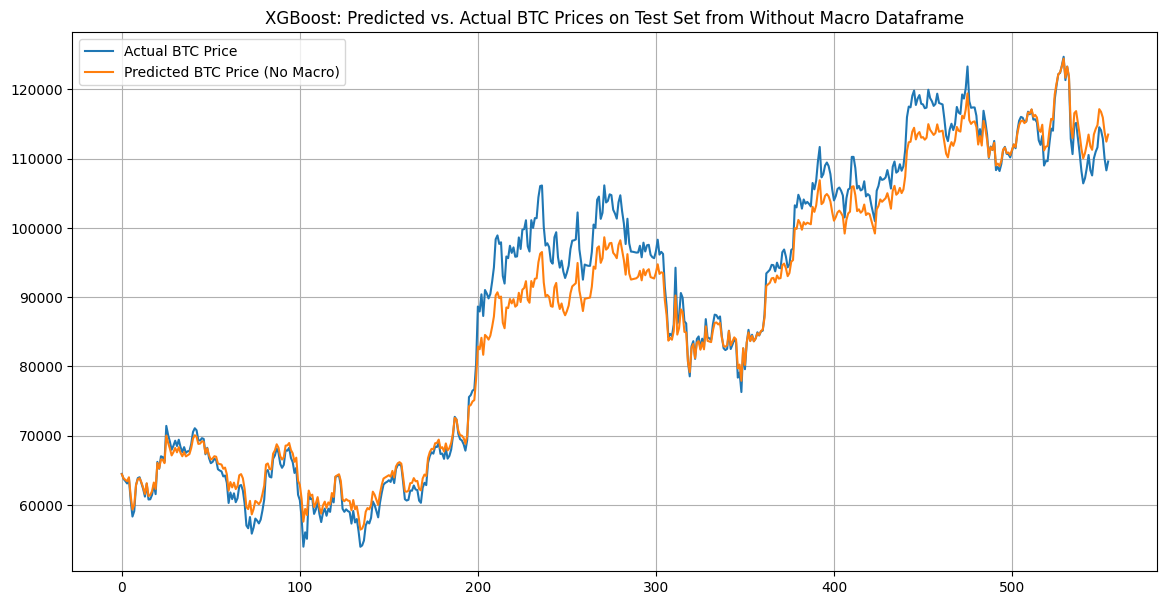

In [35]:
plt.figure(figsize=(14,7))
plt.plot(actual_price, label="Actual BTC Price")
plt.plot(pred_price_1, label="Predicted BTC Price (No Macro)")
plt.title('XGBoost: Predicted vs. Actual BTC Prices on Test Set from Without Macro Dataframe')
plt.legend(); plt.grid(); plt.show()

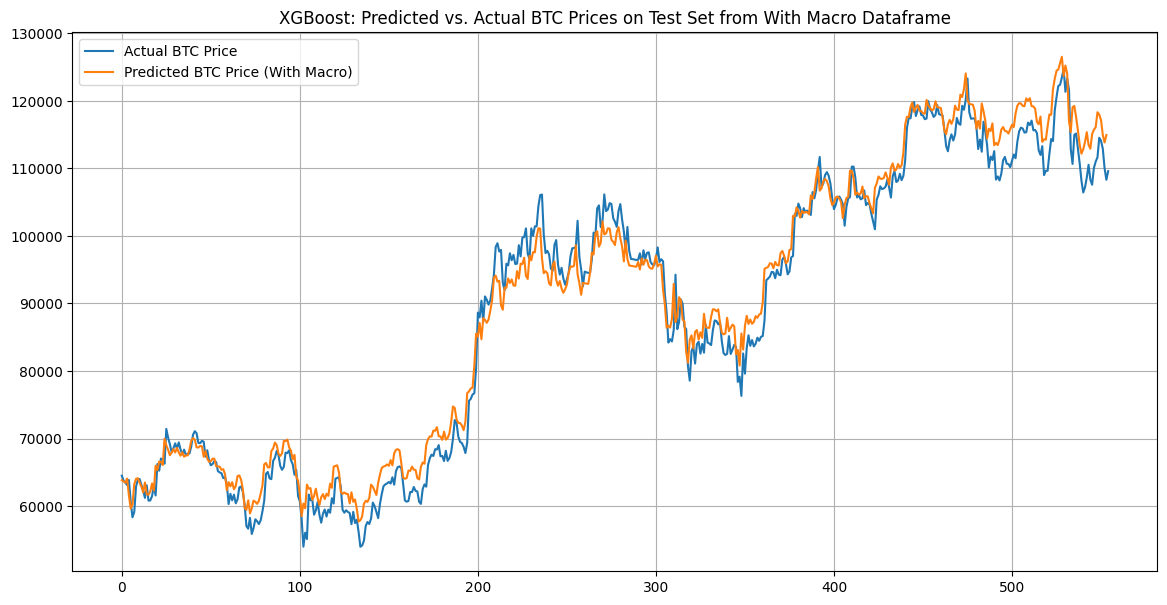

In [36]:
plt.figure(figsize=(14,7))
plt.plot(actual_price, label="Actual BTC Price")
plt.plot(pred_price_2, label="Predicted BTC Price (With Macro)")
plt.title('XGBoost: Predicted vs. Actual BTC Prices on Test Set from With Macro Dataframe')
plt.legend(); plt.grid(); plt.show()